In [1]:
import pandas as pd 
import torchaudio
from speechbrain.inference.speaker import EncoderClassifier
from scipy.io import wavfile
import noisereduce as nr
import os
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import sys
sys.path.append("../")


In [17]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

rate, data = wavfile.read('../data/vox1/Adam_Beach/profile/Adam_Beach_file10.wav')
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
embeddings = classifier.encode_batch(torch.tensor(reduced_noise).float())
embeddings

tensor([[[-18.2876,  -7.6386,  18.3548,  40.4471, -35.4675,   5.6029,  -9.6877,
          -20.8389,   5.3712,   7.3724,  48.9398,  59.5445, -47.7416,  25.7873,
          -20.8526, -11.3711,  38.6276,  12.7239, -19.9233,  27.7044,   2.5122,
            4.8166,   8.8574,   2.9774,  63.7842,   1.0733,  26.8596,  22.4435,
           -6.0466, -35.5668,  22.3496,   8.4055,   1.7153, -16.2073,  27.5217,
           10.1756,  -4.9955,   2.5517,  -3.7164,  38.3708,  -4.0641,  14.5991,
           18.9953,  18.0138, -20.1490, -15.1673,   8.5229, -18.3598,  15.5708,
           -7.0086,  11.6343,  -5.9341,  23.0765, -14.8368,  46.3982, -18.6211,
          -49.7531,  -4.6916, -20.9156, -27.2470,  24.4172,  -5.8410,   3.6865,
           -6.7195,  24.2616,  18.2403, -11.3493,  12.1391, -25.9356, -30.6469,
            3.0144,  49.6771,   9.1450, -14.1888, -19.2692, -34.6549, -32.6705,
          -20.9549, -53.5481,  25.3022, -23.9460, -14.9228,  10.6933,  49.1316,
           24.7298,  -4.8787,  20.5285, 

In [2]:

from src.auth.utils import *
load_and_encode("../data/vox1/")

Jessica_De_Gouw


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


KeyboardInterrupt: 

In [58]:
os.getcwd()

'/Users/martynagrygiel/Documents/studia/sem3/biometria/projekt2/Biometrics-Lab-Behavioral-Based-Auth/notebooks'

In [40]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import json

def load_and_encode(directory):
    embeddings = {}
    labels = []
    for person in os.listdir(directory):
        person_dir = os.path.join(directory, person, "profile")
        embs_profile = []
        print(person)
        for filename in os.listdir(person_dir):
            if filename.endswith('.wav'):
                filepath = os.path.join(person_dir, filename)
                rate, data = wavfile.read(filepath)
                reduced_noise = nr.reduce_noise(y=data, sr=rate)
                emb = classifier.encode_batch(torch.tensor(reduced_noise).float())
                embs_profile.append(emb.squeeze().detach().numpy()) 
                labels.append(person)
        embeddings[person]=np.mean(embs_profile, axis=0)
        print(type(embeddings[person]))
        data_for_df = [{'user_name': key, 'embedding': json.dumps(value.tolist())} for key, value in embeddings.items()]
        df = pd.DataFrame(data_for_df)
        df.to_csv('users_all.csv', index=False)    
    return np.array(embeddings), labels
load_and_encode("../data/vox1/")


Jessica_De_Gouw
<class 'numpy.ndarray'>
Steve_Carell
<class 'numpy.ndarray'>
Laura_Dern


KeyboardInterrupt: 

In [53]:

from scipy.spatial.distance import cosine
df = pd.read_csv("users_all.csv")
embedding_dict = dict(zip(df['user_name'], df['embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float32))))

user_names = list(embedding_dict.keys())


def authenticate(audio_path: str, threshold=0.6):
    """User authentication based on cosine similarity.

    Args:
        audio_path (str): string path to the audio file
        threshold (float, optional): Threshold thad defines the minimum cosine similarity value that should be reached to identify user. Defaults to 0.6.

    Returns:
        str| None: closest user or None if none of users is close enough
    """
    rate, data = wavfile.read(audio_path)
    reduced_noise = nr.reduce_noise(y=data, sr=rate)
    emb = classifier.encode_batch(torch.tensor(reduced_noise).float()).reshape(-1, 1).view(-1)
    closest_user = None
    min_distance = -1
    
    for user_name, stored_embedding in embedding_dict.items():
        similarity = 1 - cosine(emb, stored_embedding)
        if similarity > min_distance:
            min_distance = similarity
            closest_user = user_name
    if min_distance >= threshold:
        return closest_user
    else:
        return None

# Example usage
closest_user = authenticate('../data/vox1/Jessica_De_Gouw/test_positive/Jessica_De_Gouw_file1.wav')
closest_user

'Jessica_De_Gouw'

In [3]:
identify('../data/vox1/Jessica_De_Gouw/test_positive/Jessica_De_Gouw_file1.wav', "Jessica De Gouw")

True

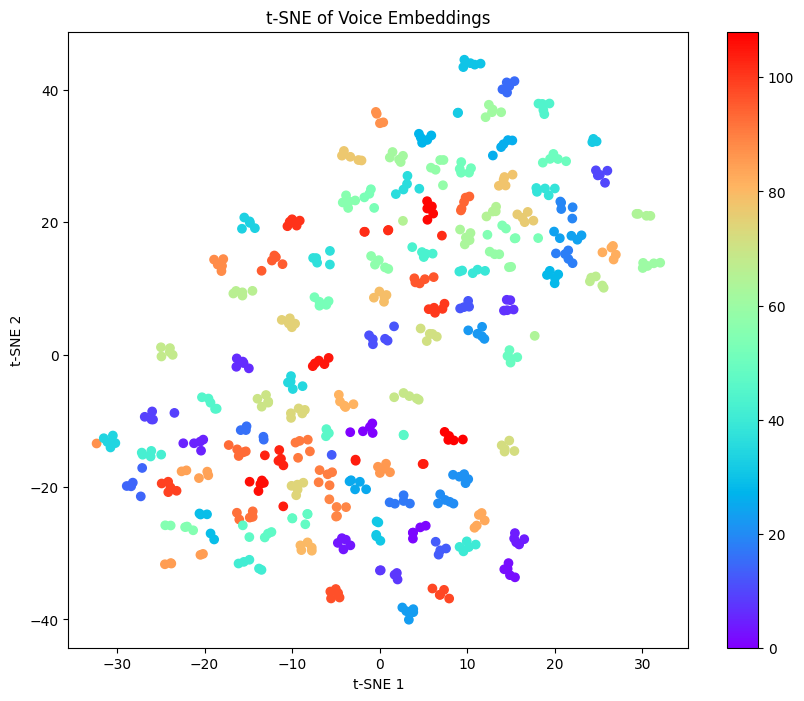

In [20]:
def load_and_encode_1(directory):
    embeddings = []
    labels = []
    for person in os.listdir(directory):
        person_dir = os.path.join(directory, person, "profile")
        i = 0
        for filename in os.listdir(person_dir):
            if i >= 5:  # Limit to 100 embeddings for faster processing
                break
            if filename.endswith('.wav'):
                filepath = os.path.join(person_dir, filename)
                rate, data = wavfile.read(filepath)
                # perform noise reduction
                reduced_noise = nr.reduce_noise(y=data, sr=rate)
                emb = classifier.encode_batch(torch.tensor(reduced_noise).float())
                embeddings.append(emb.squeeze().detach().numpy())  # Ensure it's a numpy array
                labels.append(person)
                i +=1

    
    return np.array(embeddings), labels

# Load data and encode
data_dir = "../data/vox1"
embeddings, labels = load_and_encode_1(data_dir)

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
transformed_embeddings = tsne.fit_transform(embeddings)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(transformed_embeddings[:, 0], transformed_embeddings[:, 1], cmap='rainbow', c=numeric_labels, label=labels)
plt.colorbar(scatter)
plt.title('t-SNE of Voice Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

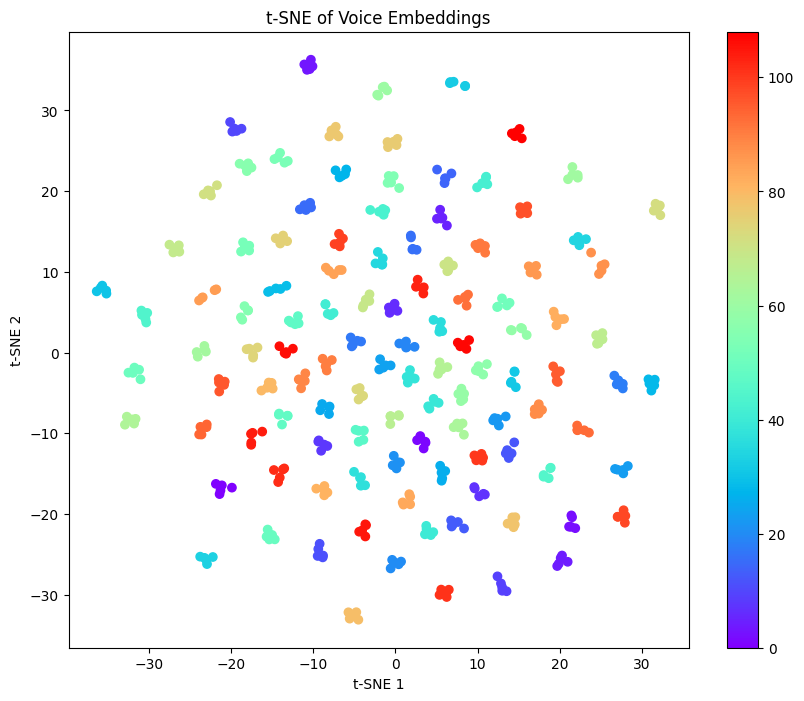

In [22]:
def load_and_encode_1(directory):
    embeddings = []
    labels = []
    for person in os.listdir(directory):
        person_dir = os.path.join(directory, person, "profile")
        i = 0
        for filename in os.listdir(person_dir):
            if i >= 5:  # Limit to 100 embeddings for faster processing
                break
            if filename.endswith('.wav'):
                filepath = os.path.join(person_dir, filename)
                rate, data = wavfile.read(filepath)
                # perform noise reduction
                emb = classifier.encode_batch(torch.tensor(data).float())
                embeddings.append(emb.squeeze().detach().numpy())  # Ensure it's a numpy array
                labels.append(person)
                i +=1

    
    return np.array(embeddings), labels

# Load data and encode
data_dir = "../data/vox1"
embeddings, labels = load_and_encode_1(data_dir)

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
transformed_embeddings = tsne.fit_transform(embeddings)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(transformed_embeddings[:, 0], transformed_embeddings[:, 1], cmap='rainbow', c=numeric_labels, label=labels)
plt.colorbar(scatter)
plt.title('t-SNE of Voice Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()